In [1]:
import os
import pandas as pd
from kernels.wrapper import MODELS, KernelModelWrapper
from dataset.ipc2023_learning_domain_info import IPC2023_LEARNING_DOMAINS, get_test_ipc2023_learning_instance_files, get_best_bound
from itertools import product
from IPython.display import display, HTML
from util.scrape_log import scrape_search_log
from util.visualise import *

In [2]:
_PAPER_DIR=str(Path.home())+"/papers/manuscripts/24-icaps-kernels"
# _PAPER_DIR=str(Path.home())+"/papers/manuscripts/23-genplan-kernels"

In [3]:
pd.options.display.float_format = "{:.1f}".format

In [4]:
_LOG_DIR = "logs/test_ipc2023"
_DIFFICULTIES = ["easy", "medium", "hard"]
_MODELS = [
  # "linear-regression",
  "lama-seq",
  "lama-first",
  "muninn", 
  "goose", 
  "ridge", 
  "lasso", 
  "linear-svr", 
  "quadratic-svr", 
  "cubic-svr",
  "rbf-svr", 
]

In [5]:
def get_data(domain):
  data = {
  }

  test_files = get_test_ipc2023_learning_instance_files()

  for model in _MODELS:
    d = {
      "solved": [],
      "expanded": [],
      "cost": [],
      "first_h": [],
      "quality": [],
      "c_opt": [],
      "difficulty": [],
      "time": [],
    }

    for difficulty in _DIFFICULTIES:
      for df, pf in test_files[domain]:
        if not difficulty in pf:
          continue
        pf_name = os.path.basename(pf).replace(".pddl", "")

        if model=="muninn":
          stats = {
            "first_h": -1,
            "solved": 0,
            "time": -1,
            "cost": -1,
            "expanded": -1,
            "evaluated": -1,
          }

          log_file = f"logs/logs_muninn/{domain}_{difficulty}_{pf_name}_domain-knowledge-{domain}.dk.log"
        
          if not os.path.exists(log_file):
            continue

          """
          [1] Subplan: 10, Heuristic: 9.998 -> goal, Expanded: 22, Generated: 86 (260 ms)
          Writing file "plan.1" (10 actions)
          Planned for 0 minutes and 0 seconds
          """

          for line in open(log_file, 'r').readlines():
            if "[1]" in line and stats['solved'] == 0:
              toks = line.replace(",", "").replace("(", "").split()
              stats["first_h"] = float(toks[4])
            if "Writing file" in line:
              toks = line.replace(",", "").replace("(", "").split()
              stats["cost"] = int(toks[-2])
              stats["solved"] = 1
        else:
          if model=="goose":
            log_file = f"{_LOG_DIR}/{domain}_{difficulty}_{pf_name}_-scratch-sv11-dc6693-trained_models_gnn-ipc2023-learning-{domain}-0.log"
          elif model=="lama-seq":
            log_file = f"logs/ipc2023_seq-sat-lama-2011/{domain}_{difficulty}_{pf_name}_seq-sat-lama-2011.log"
          elif model=="lama-first":
            log_file = f"logs/ipc2023_lama-first/{domain}_{difficulty}_{pf_name}_lama-first.log"
          else:
            log_file = f"{_LOG_DIR}/{domain}_{difficulty}_{pf_name}_-scratch-sv11-dc6693-trained_models_kernel-{model}_llg2_ipc2023-learning-{domain}_wl_1_0.joblib.log"
        
          if not os.path.exists(log_file):
            continue

          stats = scrape_search_log(log_file)


        for k in d:
          if k in stats:
            d[k].append(stats[k])
        
        c = stats["cost"]
        c_opt = get_best_bound(domain, difficulty, pf_name)
        quality = c_opt / c
        quality = max(quality, 0)
        quality = min(quality, 1)
        d["quality"].append(quality)
        d["c_opt"].append(c_opt)
        d["difficulty"].append(difficulty)
        
    data[model] = d

  return data

In [6]:
def get_metrics_df(data):
  d = {
    "config": [],
    "quality": [],
    "solved": [],
    "tried": [],
    "e_quality": [],
    "e_solved": [],
    "e_tried": [],
    "m_quality": [],
    "m_solved": [],
    "m_tried": [],
    "h_quality": [],
    "h_solved": [],
    "h_tried": [],
  }
  for config in _MODELS:
    d["config"].append(config)
    d["quality"].append(sum(data[config]["quality"]))
    d["solved"].append(sum(data[config]["solved"]))
    d["tried"].append(len(data[config]["solved"]))
    for difficulty in _DIFFICULTIES:
      quality = 0
      solved = 0
      tried = 0
      if config=="muninn":
        print(difficulty, len(data[config]["solved"]))
      for i, prob_solved in enumerate(data[config]["solved"]):
        if data[config]["difficulty"][i] == difficulty:
          quality += data[config]["quality"][i]
          solved += prob_solved
          tried += 1
      d[f"{difficulty[0]}_quality"].append(quality)
      d[f"{difficulty[0]}_solved"].append(solved)
      d[f"{difficulty[0]}_tried"].append(tried)
  return pd.DataFrame(d)

In [7]:
def get_table_df():
  d = {
    "domain": [],
  }
  for config in _MODELS:
    d[config] = []

  sum_scores = {config: 0 for config in _MODELS}

  for domain in IPC2023_LEARNING_DOMAINS:
    data = get_data(domain)
    d["domain"].append(domain)

    for config in _MODELS:
      score = sum(data[config]["quality"])
      d[config].append(score)
      sum_scores[config] += score
  

  d["domain"].append("sum")
  for config in _MODELS:
    d[config].append(sum_scores[config])

  return pd.DataFrame(d)

In [8]:
scores_df = get_table_df()
scores = scores_df.to_numpy()
scores = scores[:,1:]
display(scores_df)

,domain,lama-seq,lama-first,muninn,goose,ridge,lasso,linear-svr,quadratic-svr,cubic-svr,rbf-svr
0,blocksworld,47.0,39.8,39.0,50.5,4.9,11.5,18.9,14.1,10.4,15.7
1,childsnack,25.9,22.0,11.0,9.6,20.7,8.8,17.1,10.0,10.0,13.0
2,ferry,65.9,62.9,46.0,61.7,36.3,60.6,75.6,71.5,57.1,34.6
3,floortile,11.0,10.0,0.0,0.0,0.9,2.9,1.9,0.0,0.0,0.0
4,miconic,89.6,81.6,30.0,75.2,28.3,30.0,28.7,28.5,28.9,28.5
5,rovers,69.0,65.2,14.2,23.3,9.7,16.0,16.3,17.1,17.5,14.2
6,satellite,89.0,87.3,18.0,5.8,11.3,7.5,5.3,14.0,13.4,8.4
7,sokoban,39.2,29.8,25.2,25.8,34.8,23.0,35.0,30.5,28.0,27.9
8,spanner,30.0,30.0,32.0,30.9,24.9,30.0,25.9,25.9,26.3,25.9
9,transport,66.0,64.0,17.0,21.0,12.2,32.2,17.4,30.2,28.1,28.6


In [9]:
for domain in IPC2023_LEARNING_DOMAINS:
  print(domain)
  data = get_data(domain)
  display(get_metrics_df(data))

blocksworld
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,lama-seq,47.0,6,90,28.0,6,30,18.0,0,30,1.0,0,30
1,lama-first,39.8,61,90,20.8,30,30,17.1,27,30,1.9,4,30
2,muninn,39.0,39,90,30.0,30,30,9.0,9,30,0.0,0,30
3,goose,50.5,51,90,29.5,30,30,21.0,21,30,0.0,0,30
4,ridge,4.9,8,60,4.9,8,30,0.0,0,30,0.0,0,0
5,lasso,11.5,21,60,11.5,21,30,0.0,0,30,0.0,0,0
6,linear-svr,18.9,29,60,18.3,28,30,0.7,1,30,0.0,0,0
7,quadratic-svr,14.1,23,60,14.1,23,30,0.0,0,30,0.0,0,0
8,cubic-svr,10.4,18,60,10.4,18,30,0.0,0,30,0.0,0,0
9,rbf-svr,15.7,24,60,15.7,24,30,0.0,0,30,0.0,0,0


childsnack
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,lama-seq,25.9,9,90,22.3,9,30,3.0,0,30,0.6,0,30
1,lama-first,22.0,35,90,18.5,29,30,3.0,5,30,0.6,1,30
2,muninn,11.0,11,90,11.0,11,30,0.0,0,30,0.0,0,30
3,goose,9.6,10,90,9.6,10,30,0.0,0,30,0.0,0,30
4,ridge,20.7,28,60,20.7,28,30,0.0,0,30,0.0,0,0
5,lasso,8.8,9,60,8.8,9,30,0.0,0,30,0.0,0,0
6,linear-svr,17.1,18,60,17.1,18,30,0.0,0,30,0.0,0,0
7,quadratic-svr,10.0,10,60,10.0,10,30,0.0,0,30,0.0,0,0
8,cubic-svr,10.0,10,60,10.0,10,30,0.0,0,30,0.0,0,0
9,rbf-svr,13.0,13,60,13.0,13,30,0.0,0,30,0.0,0,0


ferry
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,lama-seq,65.9,10,90,29.9,10,30,30.0,0,30,6.0,0,30
1,lama-first,62.9,68,90,26.6,30,30,28.4,30,30,8.0,8,30
2,muninn,46.0,46,90,30.0,30,30,16.0,16,30,0.0,0,30
3,goose,61.7,62,90,29.7,30,30,30.0,30,30,2.0,2,30
4,ridge,36.3,41,90,26.9,30,30,9.3,11,30,0.0,0,30
5,lasso,60.6,61,90,29.6,30,30,30.0,30,30,1.0,1,30
6,linear-svr,75.6,76,90,29.6,30,30,30.0,30,30,16.0,16,30
7,quadratic-svr,71.5,72,90,29.5,30,30,30.0,30,30,12.0,12,30
8,cubic-svr,57.1,58,90,29.1,30,30,26.9,27,30,1.0,1,30
9,rbf-svr,34.6,35,90,29.6,30,30,5.0,5,30,0.0,0,30


floortile
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,lama-seq,11.0,10,90,11.0,10,30,0,0,30,0,0,30
1,lama-first,10.0,11,90,10.0,11,30,0,0,30,0,0,30
2,muninn,0.0,0,90,0.0,0,30,0,0,30,0,0,30
3,goose,0.0,0,90,0.0,0,30,0,0,30,0,0,30
4,ridge,0.9,1,30,0.9,1,30,0,0,0,0,0,0
5,lasso,2.9,3,30,2.9,3,30,0,0,0,0,0,0
6,linear-svr,1.9,2,30,1.9,2,30,0,0,0,0,0,0
7,quadratic-svr,0.0,0,30,0.0,0,30,0,0,0,0,0,0
8,cubic-svr,0.0,0,30,0.0,0,30,0,0,0,0,0,0
9,rbf-svr,0.0,0,30,0.0,0,30,0,0,0,0,0,0


miconic
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,lama-seq,89.6,30,90,30.0,30,30,30.0,0,30,29.6,0,30
1,lama-first,81.6,90,90,25.5,30,30,29.2,30,30,26.9,30,30
2,muninn,30.0,30,90,30.0,30,30,0.0,0,30,0.0,0,30
3,goose,75.2,76,90,29.2,30,30,30.0,30,30,16.0,16,30
4,ridge,28.3,30,60,28.3,30,30,0.0,0,30,0.0,0,0
5,lasso,30.0,30,60,30.0,30,30,0.0,0,30,0.0,0,0
6,linear-svr,28.7,30,60,28.7,30,30,0.0,0,30,0.0,0,0
7,quadratic-svr,28.5,30,60,28.5,30,30,0.0,0,30,0.0,0,0
8,cubic-svr,28.9,30,60,28.9,30,30,0.0,0,30,0.0,0,0
9,rbf-svr,28.5,30,60,28.5,30,30,0.0,0,30,0.0,0,0


rovers
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,lama-seq,69.0,12,90,30.0,12,30,30.0,0,30,9.0,0,30
1,lama-first,65.2,67,89,28.3,30,30,27.8,28,29,9.0,9,30
2,muninn,14.2,15,90,14.2,15,30,0.0,0,30,0.0,0,30
3,goose,23.3,28,90,23.3,28,30,0.0,0,30,0.0,0,30
4,ridge,9.7,13,60,9.7,13,30,0.0,0,30,0.0,0,0
5,lasso,16.0,19,60,16.0,19,30,0.0,0,30,0.0,0,0
6,linear-svr,16.3,22,60,16.3,22,30,0.0,0,30,0.0,0,0
7,quadratic-svr,17.1,21,60,17.1,21,30,0.0,0,30,0.0,0,0
8,cubic-svr,17.5,22,60,17.5,22,30,0.0,0,30,0.0,0,0
9,rbf-svr,14.2,18,60,14.2,18,30,0.0,0,30,0.0,0,0


satellite
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,lama-seq,89.0,12,90,30.0,12,30,30,0,30,29,0,30
1,lama-first,87.3,89,90,28.3,30,30,30,30,30,29,29,30
2,muninn,18.0,18,90,16.0,16,30,2,2,30,0,0,30
3,goose,5.8,11,90,5.8,11,30,0,0,30,0,0,30
4,ridge,11.3,23,60,11.3,23,30,0,0,30,0,0,0
5,lasso,7.5,12,60,7.5,12,30,0,0,30,0,0,0
6,linear-svr,5.3,15,60,5.3,15,30,0,0,30,0,0,0
7,quadratic-svr,14.0,24,60,14.0,24,30,0,0,30,0,0,0
8,cubic-svr,13.4,24,60,13.4,24,30,0,0,30,0,0,0
9,rbf-svr,8.4,16,60,8.4,16,30,0,0,30,0,0,0


sokoban
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,lama-seq,39.2,27,90,30.0,27,30,9.2,0,30,0,0,30
1,lama-first,29.8,40,90,22.4,30,30,7.4,10,30,0,0,30
2,muninn,25.2,27,90,25.2,27,30,0.0,0,30,0,0,30
3,goose,25.8,29,90,24.8,28,30,1.0,1,30,0,0,30
4,ridge,34.8,38,90,26.9,30,30,8.0,8,30,0,0,30
5,lasso,23.0,23,90,23.0,23,30,0.0,0,30,0,0,30
6,linear-svr,35.0,38,90,27.0,30,30,8.0,8,30,0,0,30
7,quadratic-svr,30.5,33,90,26.7,29,30,3.7,4,30,0,0,30
8,cubic-svr,28.0,31,90,27.0,30,30,1.0,1,30,0,0,30
9,rbf-svr,27.9,30,90,27.9,30,30,0.0,0,30,0,0,30


spanner
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,lama-seq,30.0,30,90,30.0,30,30,0.0,0,30,0,0,30
1,lama-first,30.0,30,90,30.0,30,30,0.0,0,30,0,0,30
2,muninn,32.0,32,90,30.0,30,30,2.0,2,30,0,0,30
3,goose,30.9,35,90,25.9,30,30,5.0,5,30,0,0,30
4,ridge,24.9,29,60,24.9,29,30,0.0,0,30,0,0,0
5,lasso,30.0,30,60,30.0,30,30,0.0,0,30,0,0,0
6,linear-svr,25.9,30,60,25.9,30,30,0.0,0,30,0,0,0
7,quadratic-svr,25.9,30,60,25.9,30,30,0.0,0,30,0,0,0
8,cubic-svr,26.3,30,60,26.3,30,30,0.0,0,30,0,0,0
9,rbf-svr,25.9,30,60,25.9,30,30,0.0,0,30,0,0,0


transport
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,lama-seq,66.0,8,90,30.0,8,30,30.0,0,30,6,0,30
1,lama-first,64.0,66,90,28.0,30,30,30.0,30,30,6,6,30
2,muninn,17.0,17,90,17.0,17,30,0.0,0,30,0,0,30
3,goose,21.0,25,90,20.4,24,30,0.7,1,30,0,0,30
4,ridge,12.2,21,60,10.5,18,30,1.6,3,30,0,0,0
5,lasso,32.2,33,60,29.2,30,30,3.0,3,30,0,0,0
6,linear-svr,17.4,26,60,15.7,23,30,1.7,3,30,0,0,0
7,quadratic-svr,30.2,32,60,28.4,30,30,1.8,2,30,0,0,0
8,cubic-svr,28.1,30,60,28.1,30,30,0.0,0,30,0,0,0
9,rbf-svr,28.6,31,60,27.6,30,30,1.0,1,30,0,0,0


In [10]:
""" scores.tex """
ret  = r"\begin{tabular}{" + " ".join(["c" for _ in range(len(_MODELS)+1)]) + r"} \toprule Domain "
for model in _MODELS:
  ret += f"& \\header{{\{model.replace('-', '')}}} "
ret += r"\\ \midrule" + '\n'

for domain, scores_domain in zip(IPC2023_LEARNING_DOMAINS, scores):
  ret += domain
  best_score = max(scores_domain)
  for score in scores_domain:
    if score==best_score:
      ret += f" & \\textbf{{{score:.1f}}}"
    else:
      ret += f" & {score:.1f}"
  ret += "\\\\ \n"

ret += "\midrule  sum"
best_score = max(scores[-1])
for score in scores[-1]:
    if score==best_score:
      ret += f" & \\textbf{{{score:.1f}}}"
    else:
      ret += f" & {score:.1f}"
ret += "\\\\"

ret += r"\bottomrule\end{tabular}"

f = open(f"{_PAPER_DIR}/figures/scores.tex", 'w')
f.write(ret)
f.close()

In [11]:
""" coverage2.tex """

scores_df = get_table_df()
scores = scores_df.to_numpy()
scores = scores[:,1:]

ret  = r"\begin{tabular}{" + " ".join(["c" for _ in range(len(_MODELS)+1)]) + r"} \toprule Domain "
for model in _MODELS:
    ret += f"& \\header{{\{model.replace('-', '')}}} "
ret += r"\\ \midrule" + '\n'

all_solved = {
  "easy": np.zeros(len(_MODELS)).astype(int),
  "medium": np.zeros(len(_MODELS)).astype(int),
  "hard": np.zeros(len(_MODELS)).astype(int),
  "all": np.zeros(len(_MODELS)).astype(int),
}

for domain, scores_domain in zip(IPC2023_LEARNING_DOMAINS, scores):
  ret += f"\\multirow{{2}}{{*}}{{{domain}}}"
  data = (get_metrics_df(get_data(domain)).to_numpy())
  solved = {
    "easy": data[:,5].T,
    "medium": data[:,8].T,
    "hard": data[:,11].T,
  }

  for i in range(len(solved["easy"])):
    chunks = []
    for difficulty in solved:

      scores_domain = solved[difficulty]
      if i==0:
        all_solved[difficulty] += scores_domain.astype(int)
      best_score = max(scores_domain)
      score = solved[difficulty][i]
      if score == 0:
        chunks.append("-")
      elif score==best_score:
        chunks.append(f"\\textbf{{{score}}}")
      else:
        chunks.append(f"{score}")

    chunk = "/".join(chunks)
    ret += f" & {chunk}"
  ret += "\\\\ \n"

  solved = {
    "all": data[:,2].T,
  }

  for i in range(len(solved["all"])):
    chunks = []
    for difficulty in solved:

      scores_domain = solved[difficulty]
      if i==0:
        all_solved[difficulty] += scores_domain.astype(int)
      best_score = max(scores_domain)
      score = solved[difficulty][i]
      if score == 0:
        chunks.append("-")
      elif score==best_score:
        chunks.append(f"\\textbf{{{score}}}")
      else:
        chunks.append(f"{score}")

    chunk = "/".join(chunks)
    ret += f" & {chunk}"
  
  if domain==IPC2023_LEARNING_DOMAINS[-1]:
    ret += "\\\\ \midrule \n"
  else:
    ret += "\\\\ \cmidrule(lr){2-" + str(len(_MODELS)+1) + "} \n"

ret += f"\\multirow{{2}}{{*}}{{sum}}"
for i in range(len(all_solved["all"])):
    chunks = []
    for difficulty in ["easy", "medium", "hard"]:

        scores_domain = all_solved[difficulty]
        best_score = max(scores_domain)
        score = all_solved[difficulty][i]
        print(score, best_score)
        if score == 0:
          chunks.append("-")
        elif score==best_score:
          chunks.append(f"\\textbf{{{score}}}")
        else:
          chunks.append(f"{score}")

    chunk = "/".join(chunks)
    ret += f" & {chunk}"

ret += r" \\ "

for i in range(len(all_solved["all"])):
    chunks = []
    for difficulty in ["all"]:

        scores_domain = all_solved[difficulty]
        best_score = max(scores_domain)
        score = all_solved[difficulty][i]
        print(score, best_score)
        if score == 0:
          chunks.append("-")
        elif score==best_score:
          chunks.append(f"\\textbf{{{score}}}")
        else:
          chunks.append(f"{score}")

    chunk = "/".join(chunks)
    ret += f" & {chunk}"

ret += r" \\ \bottomrule\end{tabular}"

f = open(f"{_PAPER_DIR}/figures/coverage2.tex", 'w')
f.write(ret)
f.close()

easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
easy 90
medium 90
hard 90
154 280
0 190
0 87
280 280
190 190
87 87
206 280
29 190
0 87
221 280
88 190
18 87
210 280
22 190
0 87
207 280
33 190
1 87
228 280
42 190
16 87
227 280
36 190
12 87
224 280
28 190
1 87
221 280
6 190
0 87
154 557
557 557
235 557
327 557
232 557
241 557
286 557
275 557
253 557
227 557


blocksworld


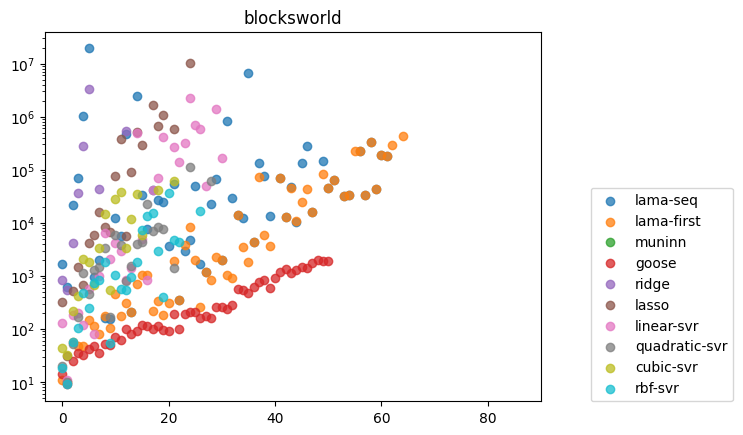

childsnack


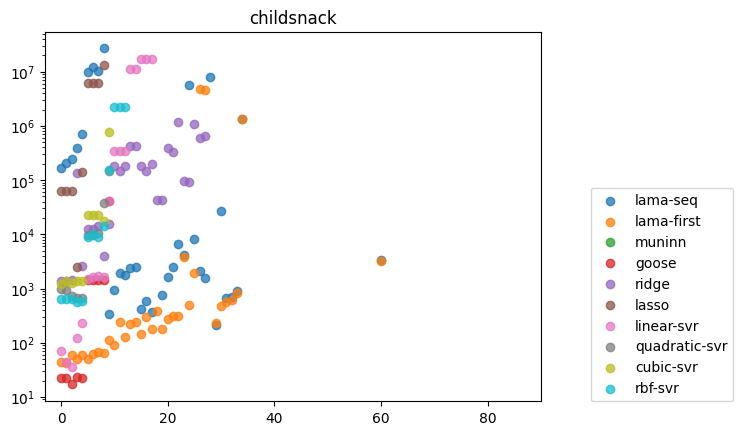

ferry


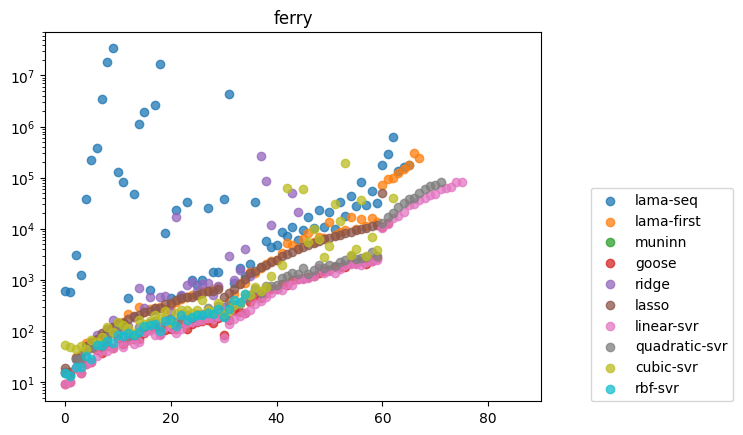

floortile


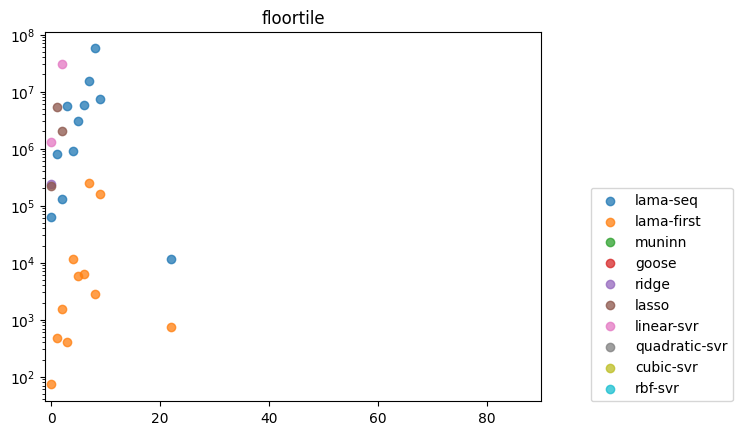

miconic


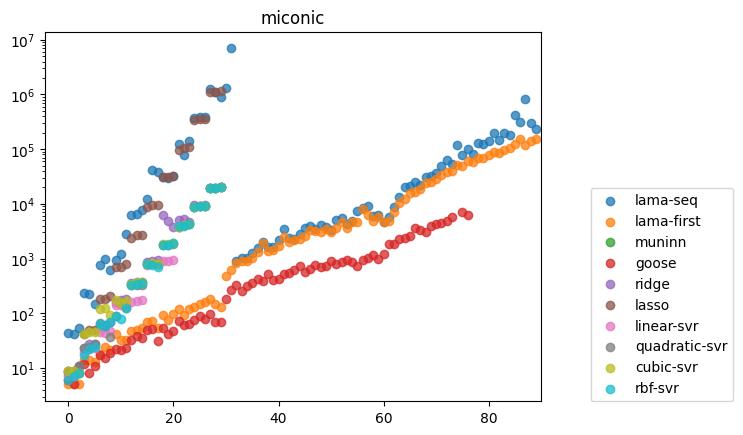

rovers


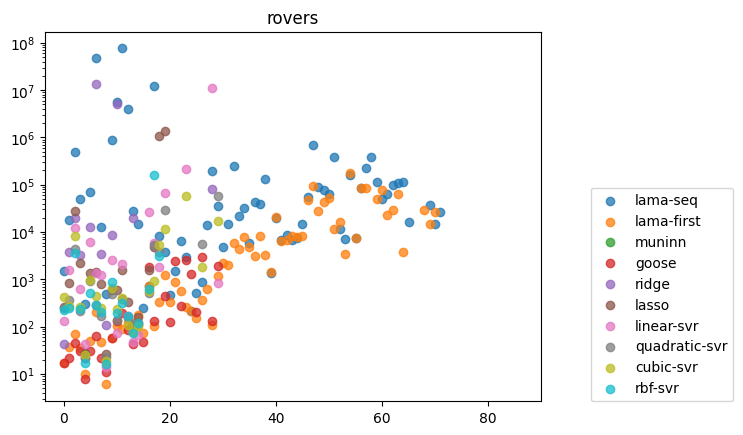

satellite


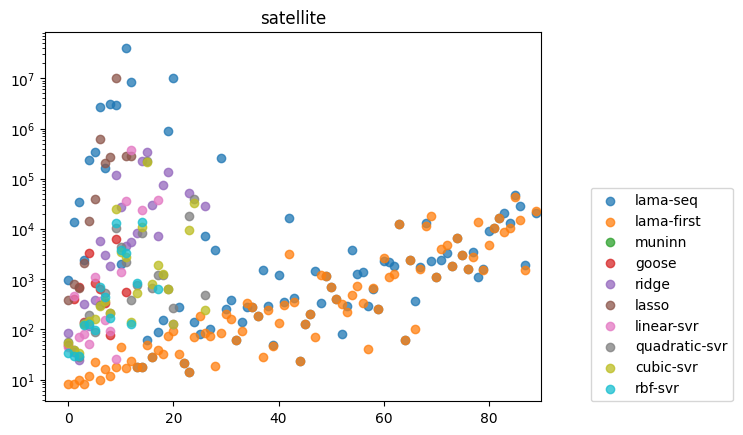

sokoban


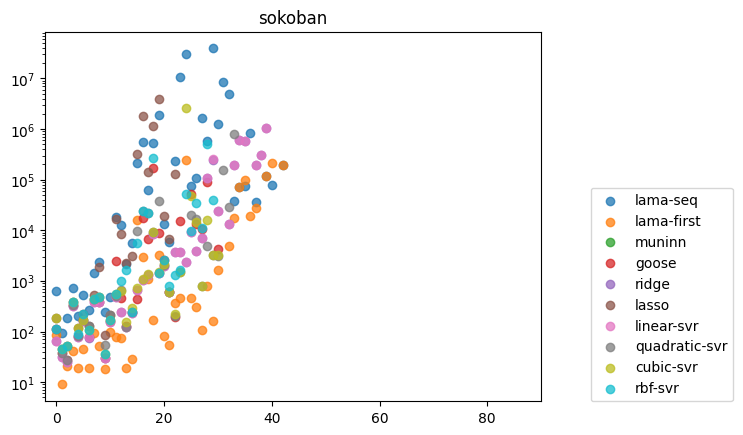

spanner


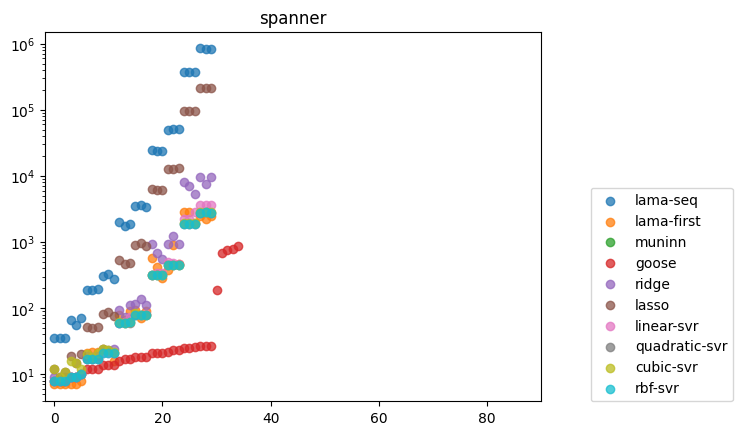

transport


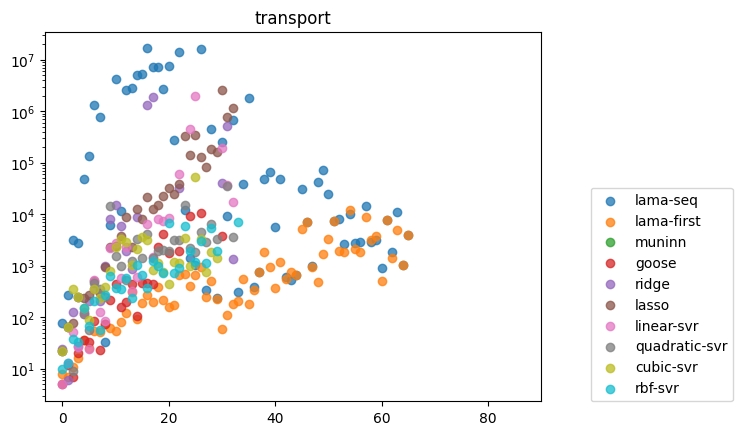

<Figure size 640x480 with 0 Axes>

In [12]:
""" expansions """
for domain in IPC2023_LEARNING_DOMAINS:
  print(domain)
  data = get_data(domain)
  for model in _MODELS:
    xs = []
    ys = []
    for i, expanded in enumerate(data[model]["expanded"]):
      if expanded!=-1:
        xs.append(i)
        ys.append(expanded)
    plt.scatter(xs, ys, label=model, alpha=0.75)
  plt.yscale("log")
  plt.xlim(right=90)
  plt.legend(loc=(1.1, 0))
  plt.title(domain)
  plt.show()
  plt.clf()

blocksworld


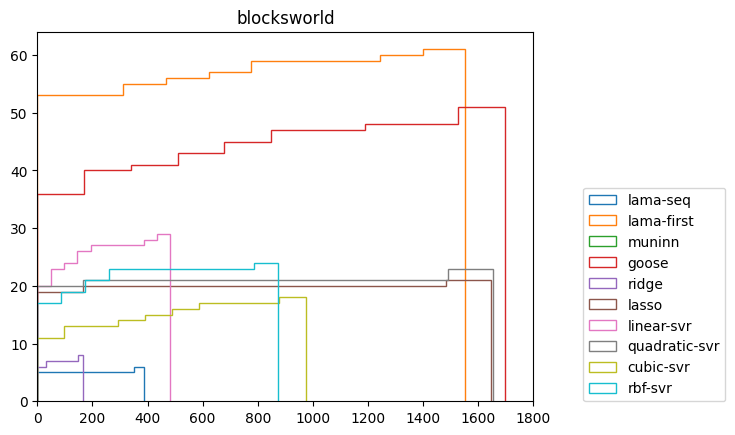

childsnack


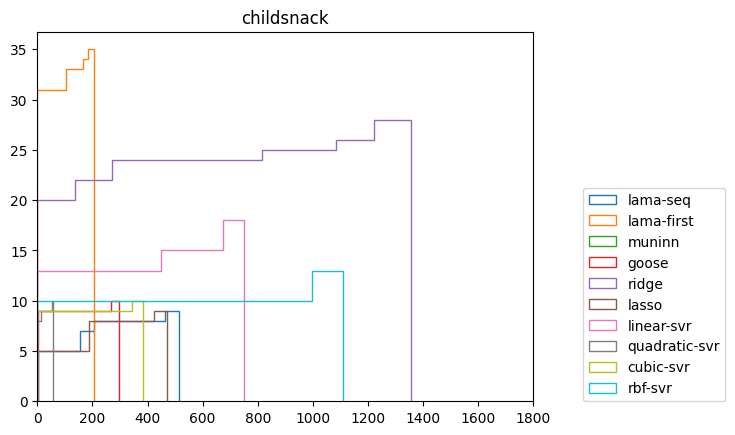

ferry


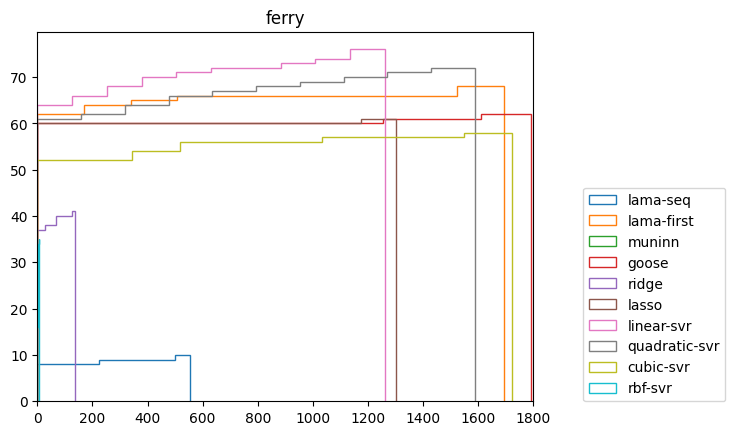

floortile


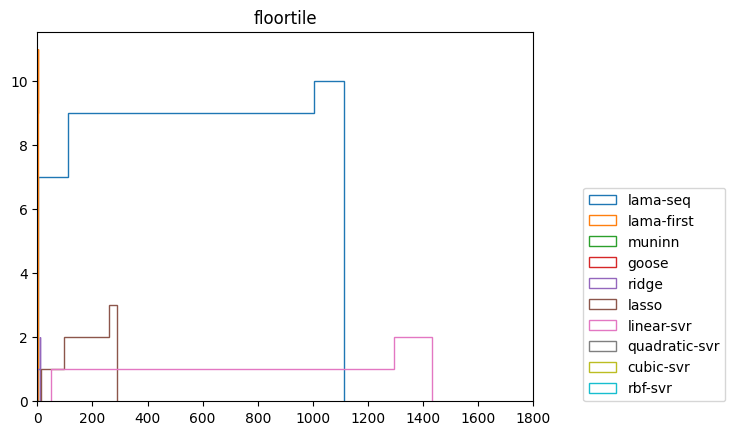

miconic


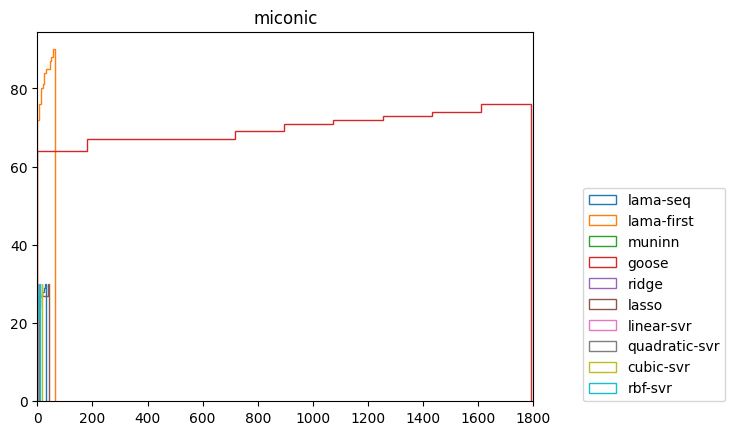

rovers


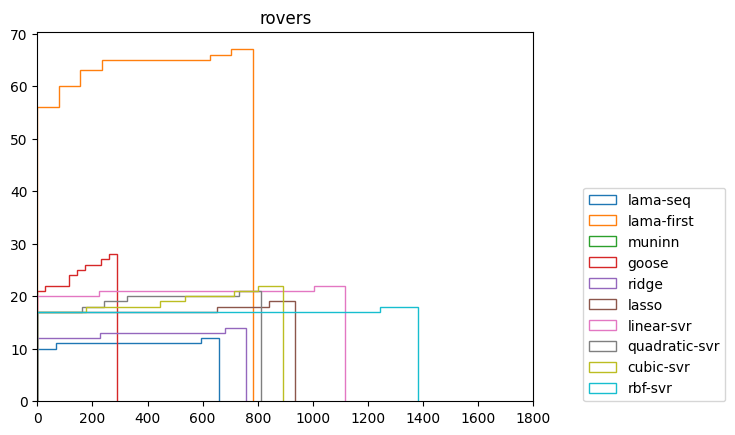

satellite


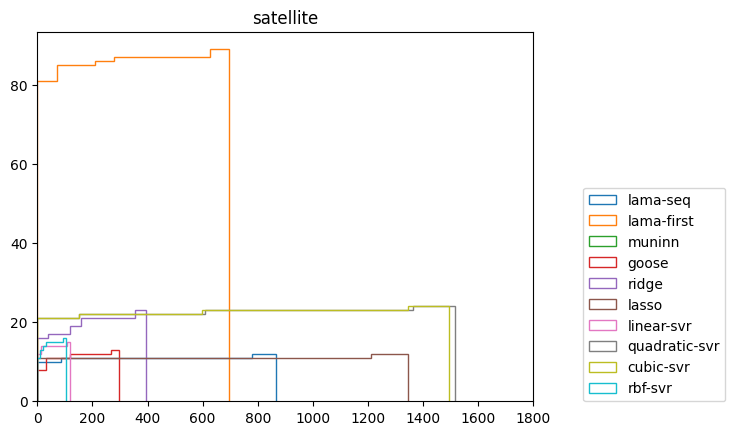

sokoban


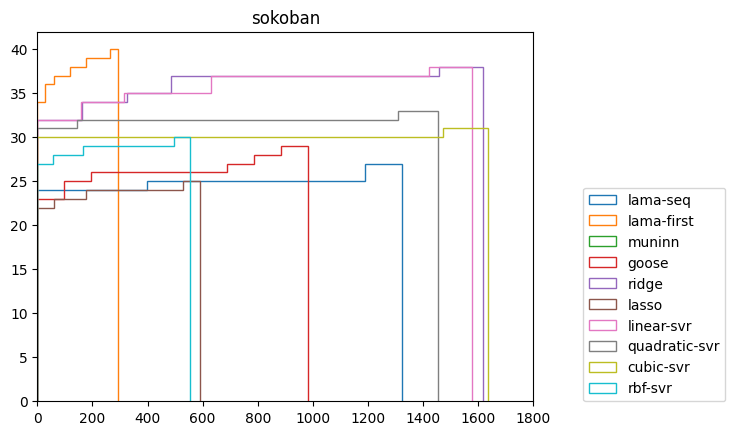

spanner


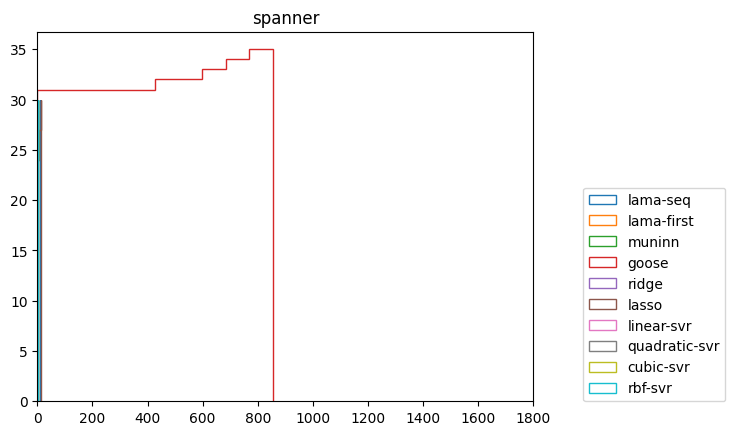

transport


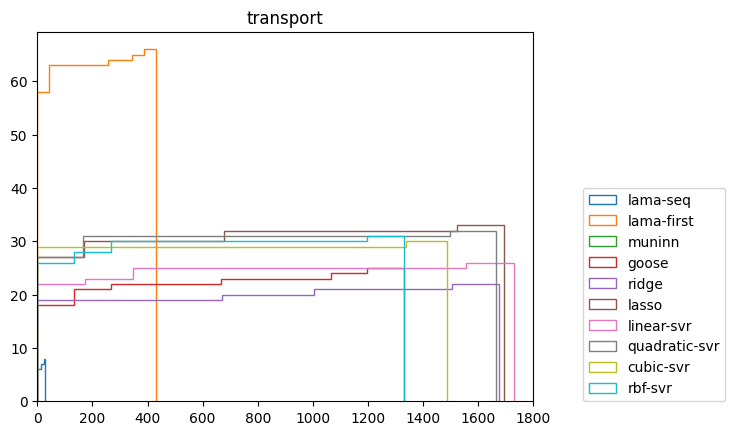

<Figure size 640x480 with 0 Axes>

In [13]:
""" cumulative runtime """
for domain in IPC2023_LEARNING_DOMAINS:
  print(domain)
  data = get_data(domain)
  for model in _MODELS:
    ys = []
    for i, runtime in enumerate(data[model]["time"]):
      if runtime!=-1:
        ys.append(runtime)
    ys += []
    plt.hist(ys, cumulative=True, histtype='step', label=model)
  plt.xlim(left=0, right=1800)
  plt.legend(loc=(1.1, 0))
  plt.title(domain)
  plt.show()
  plt.clf()

In [14]:
os.makedirs("plots", exist_ok=True)
for domain in IPC2023_LEARNING_DOMAINS:
  try:
    data = get_data(domain)

    max_val = 0

    for config in CONFIGS:
      cs = np.array(data[config]["cost"])
      c_opts = np.array(data[config]["c_opt"])
      index = np.where(cs != -1)
      cs = cs[index]
      c_opts = c_opts[index]
      plt.scatter(c_opts, cs, label="_".join(config))
      max_val = max([max_val, max(cs), max(c_opts)])
    
    plt.title(domain)
    plt.plot([1, max_val], [1, max_val], alpha=0.5, linestyle="dotted", c='k')
    plt.ylabel("C")
    plt.xlabel("C* (not necessarily optimal)")
    plt.legend()
    # plt.show()
    plt.savefig(f"plots/{_REP}_cost_ipc2023-learning-{domain}.png")
  except:
    pass
  plt.clf()
print("c vs c* saved")

c vs c* saved


<Figure size 640x480 with 0 Axes>

NameError: name 'CONFIGS' is not defined

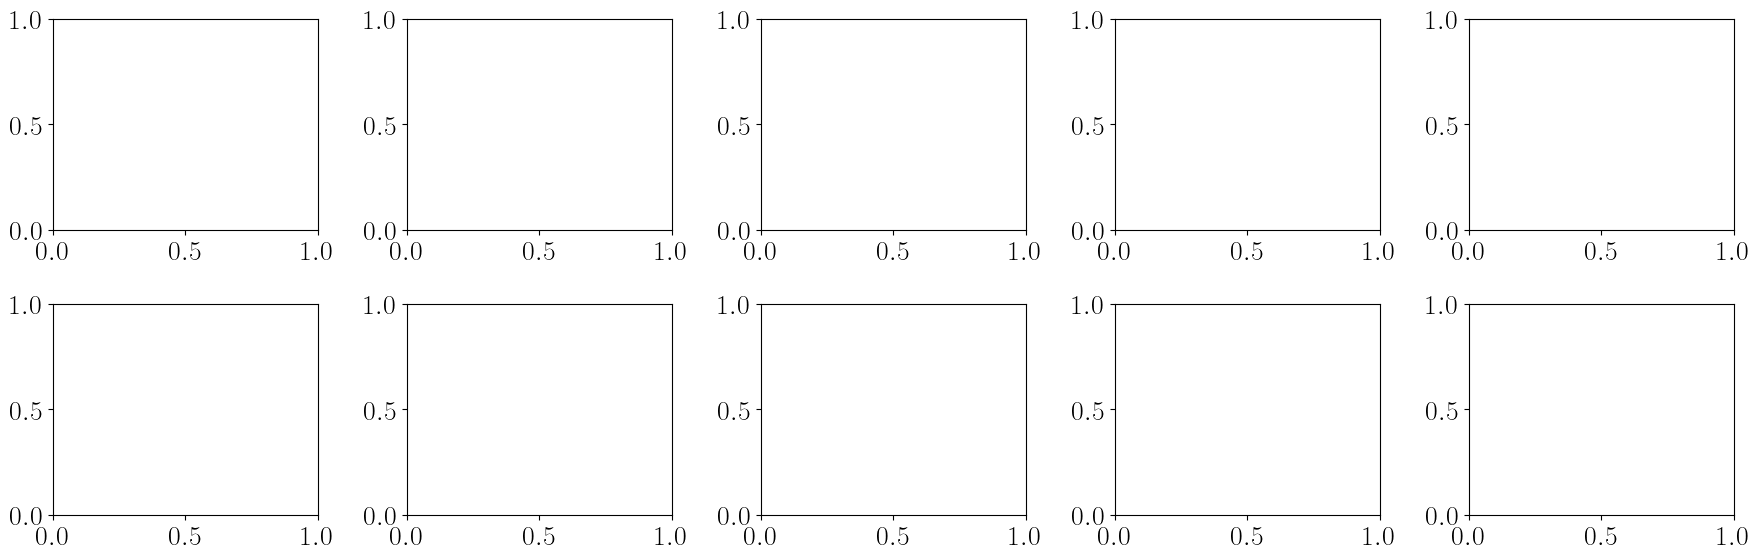

In [15]:
plt.rcParams.update({
  "text.usetex": True,
  "font.size": 20,
})

fig, axs = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False, figsize=(18, 6))
fig.tight_layout()

for k, domain in enumerate(IPC2023_LEARNING_DOMAINS):
  i = k // 5
  j = k % 5
  data = get_data(domain)
  max_val = 0

  for config in ["muninn"] + CONFIGS:
    cs = np.array(data[config]["cost"])
    c_opts = np.array(data[config]["c_opt"])
    index = np.where(cs != -1)
    cs = cs[index]
    c_opts = c_opts[index]
    label = "Muninn" if config == "muninn" else config[0]
    if config=="muninn":
      marker='*'
    elif "svr" in config[0]:
      marker='x'
    else:
      marker='o'
    axs[i,j].scatter(c_opts, cs, label=label, alpha=0.6, marker=marker)
    try:
      max_val = max([max_val, max(cs), max(c_opts)])
    except:
      pass
  
  axs[i,j].plot([1, max_val], [1, max_val], alpha=0.5, linestyle="dotted", c='k')
  axs[i,j].set_title(domain)

plt.legend(loc=(1.1, 0.5))
plt.savefig(f"{_PAPER_DIR}/figures/cost.pdf", bbox_inches="tight")
plt.show()

In [ ]:
os.makedirs("plots", exist_ok=True)
for domain in IPC2023_LEARNING_DOMAINS:
  try:
    data = get_data(domain)

    max_val = 0

    my_dict = {}

    fig, ax = plt.subplots()

    for config in CONFIGS:
      expanded = np.array(data[config]["expanded"])
      # index = np.where(expanded != -1)
      expanded = expanded[index]
      my_dict["_".join(config)] = expanded
    
    plt.yscale("log")
    plt.title(domain)
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())
    # plt.ylim(bottom=1)
    # plt.show()
    plt.savefig(f"plots/{_REP}_expanded_ipc2023-learning-{domain}.png")
  except:
    pass
  plt.clf()
print("expansions saved")

expansions saved


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>